In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
import anndata as ad
import decoupler
import seaborn.objects as so

In [2]:
import sys
sys.path.append('/home/mowp/workspace/mowp_scripts/tools')


import os
os.environ['R_HOME'] = '/home/mowp/mambaforge/envs/sc/lib/R'

%load_ext autoreload
%autoreload 1
%aimport sctk

In [25]:
sc.set_figure_params(figsize=(4, 4))

In [4]:
os.chdir('/data/user/mowp/workspace/single_cell_analysis')

# GSEA

In [13]:
adata = sctk.sample_data.kang_counts_25k()

In [15]:
sctk.pp.scanpy_pp(adata, n_top_genes=4000)

In [16]:
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'leiden'
    var: 'name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [18]:
adata.obs = adata.obs.rename({"label": "condition"}, axis=1)

/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


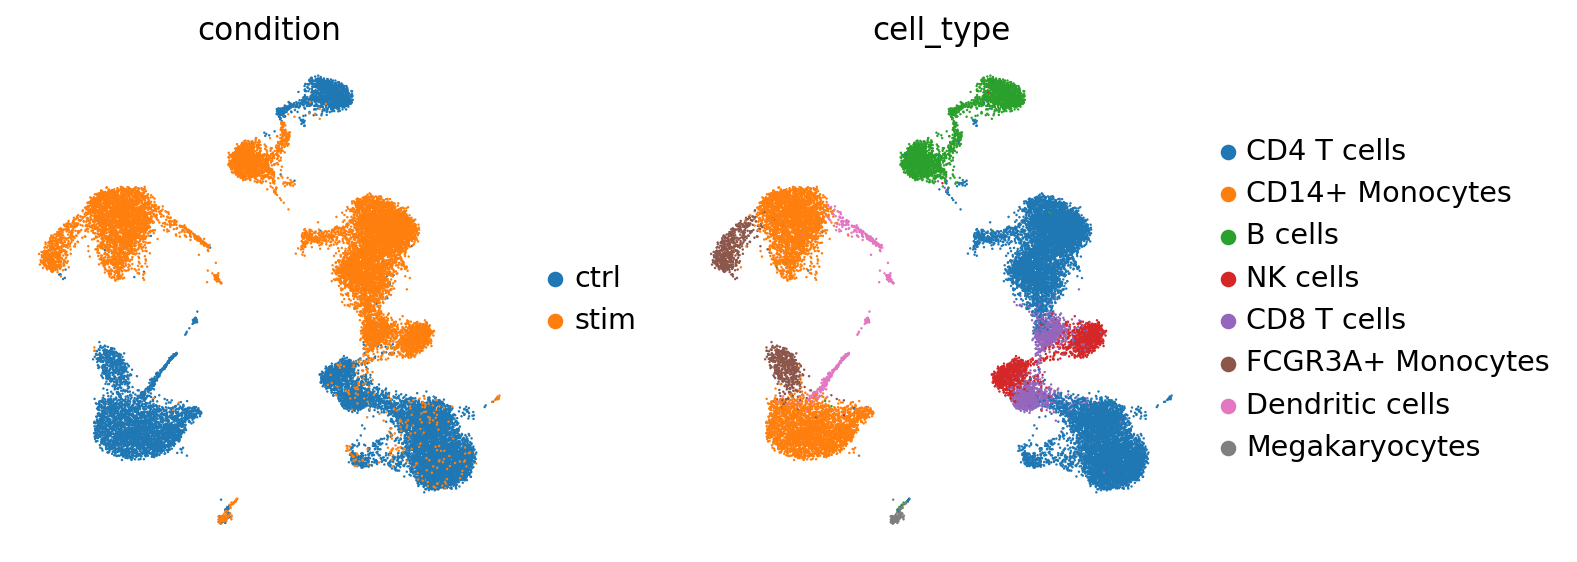

In [21]:
sc.pl.umap(
    adata,
    color=["condition", "cell_type"],
    frameon=False,
    ncols=2,
)


In [22]:
adata.obs["group"] = adata.obs.condition.astype("string") + "_" + adata.obs.cell_type

In [23]:
# find DE genes by t-test
sc.tl.rank_genes_groups(adata, "group", method="t-test", key_added="t-test")

In [25]:
celltype_condition = "stim_FCGR3A+ Monocytes"  # 'stimulated_B',  'stimulated_CD8 T', 'stimulated_CD14 Mono'

In [26]:
# extract scores
t_stats = (
    # Get dataframe of DE results for condition vs. rest
    sc.get.rank_genes_groups_df(adata, celltype_condition, key="t-test")
    # Subset to highly variable genes
    .set_index("names")
    .loc[adata.var["highly_variable"]]
    # Sort by absolute score
    .sort_values("scores", key=np.abs, ascending=False)
    # Format for decoupler
    [["scores"]]
    .rename_axis(["stim_FCGR3A+ Monocytes"], axis=1)
)
t_stats

# 将全部基因按照某种指标（差异分析p值，表型相关性，表达量等）进行排序，比如log2FC排序

stim_FCGR3A+ Monocytes,scores
names,
IFITM3,177.324463
ISG15,142.359955
TYROBP,136.308289
TNFSF10,127.381111
S100A11,115.320427
...,...
MDFIC,0.004189
FBXO8,0.003711
AKIP1,0.002908


In [11]:
from pathlib import Path

def gmt_to_decoupler(pth: Path) -> pd.DataFrame:
    """
    Parse a gmt file to a decoupler pathway dataframe.
    """
    from itertools import chain, repeat

    pathways = {}

    with Path(pth).open("r") as f:
        for line in f:
            name, _, *genes = line.strip().split("\t")
            pathways[name] = genes

    return pd.DataFrame.from_records(
        chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()),
        columns=["geneset", "genesymbol"],
    )

In [27]:
infile = '/data/user/mowp/workspace/single_cell_analysis/single-cell-best-practics/c2.cp.reactome.v7.5.1.symbols.gmt'

In [30]:
reactome = gmt_to_decoupler(infile)

In [31]:
reactome

,geneset,genesymbol
0,REACTOME_INTERLEUKIN_6_SIGNALING,JAK2
1,REACTOME_INTERLEUKIN_6_SIGNALING,TYK2
2,REACTOME_INTERLEUKIN_6_SIGNALING,CBL
3,REACTOME_INTERLEUKIN_6_SIGNALING,STAT1
4,REACTOME_INTERLEUKIN_6_SIGNALING,IL6ST
...,...,...
89471,REACTOME_ION_CHANNEL_TRANSPORT,FXYD7
89472,REACTOME_ION_CHANNEL_TRANSPORT,UBA52
89473,REACTOME_ION_CHANNEL_TRANSPORT,ATP6V1E2
89474,REACTOME_ION_CHANNEL_TRANSPORT,ASIC5


In [33]:
# Filtering genesets to match behaviour of fgsea
geneset_size = reactome.groupby("geneset").size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

In [35]:
scores, norm, pvals = decoupler.run_gsea(
    t_stats.T,
    reactome[reactome["geneset"].isin(gsea_genesets)],
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)

In [43]:
t_stats

stim_FCGR3A+ Monocytes,scores
names,
IFITM3,177.324463
ISG15,142.359955
TYROBP,136.308289
TNFSF10,127.381111
S100A11,115.320427
...,...
MDFIC,0.004189
FBXO8,0.003711
AKIP1,0.002908


In [38]:
gsea_results

,score,norm,pval
source,,,
REACTOME_MHC_CLASS_II_ANTIGEN_PRESENTATION,0.746403,1.935574,0.000000
REACTOME_NEUTROPHIL_DEGRANULATION,0.690652,2.189166,0.000000
REACTOME_INTERFERON_ALPHA_BETA_SIGNALING,0.901755,2.152574,0.000000
REACTOME_DDX58_IFIH1_MEDIATED_INDUCTION_OF_INTERFERON_ALPHA_BETA,0.789095,1.858248,0.000000
REACTOME_RRNA_PROCESSING,-0.717747,-1.872656,0.000000
...,...,...,...
REACTOME_TRIGLYCERIDE_CATABOLISM,0.193899,0.357059,0.997817
REACTOME_SUMOYLATION_OF_CHROMATIN_ORGANIZATION_PROTEINS,0.181207,0.373793,0.997831
REACTOME_SUMOYLATION_OF_DNA_DAMAGE_RESPONSE_AND_REPAIR_PROTEINS,-0.199669,-0.504418,0.997972


/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mowp/mambaforge/envs/sc/lib/python3.9/site-packages/seaborn/_core/plot.py:941: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.savefig(buffer, dpi=dpi * 2, format="png", bbox_inches="tight")


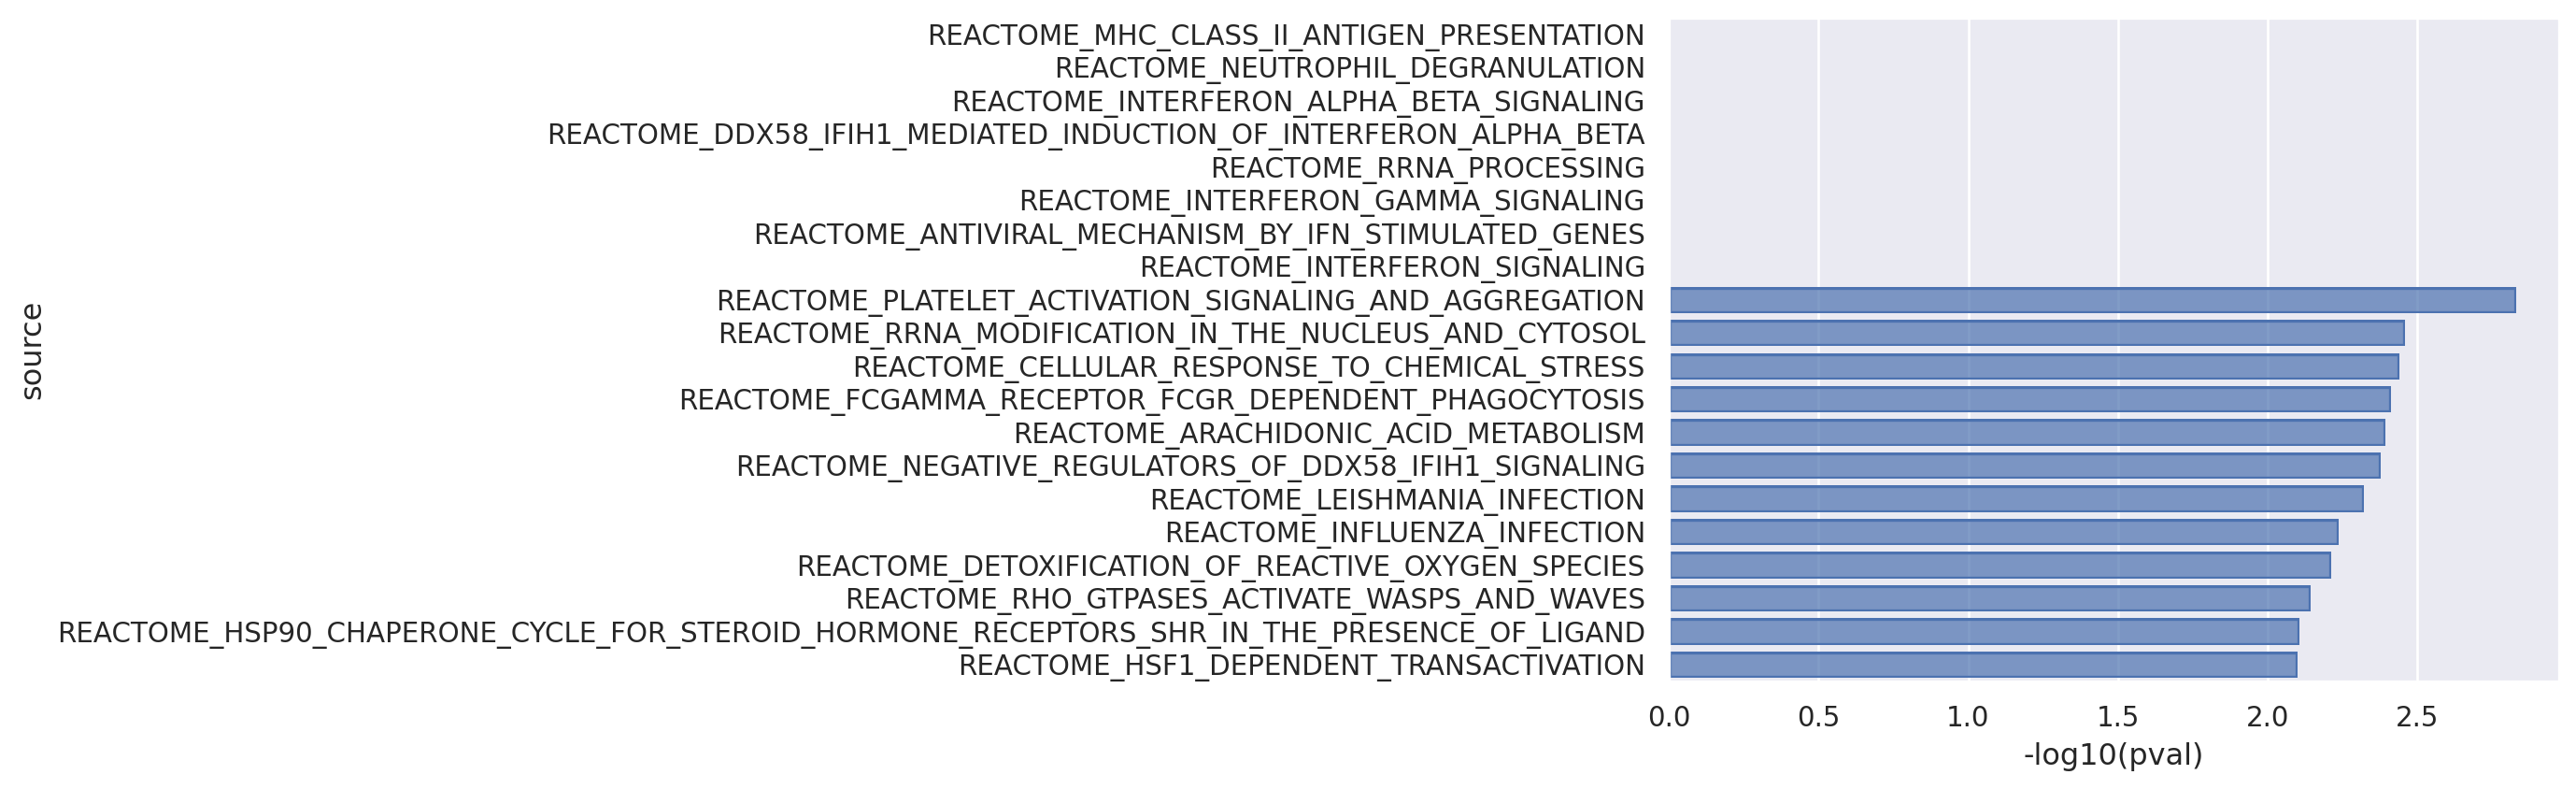

In [37]:
(
    so.Plot(
        data=(
            gsea_results.head(20).assign(
                **{"-log10(pval)": lambda x: -np.log10(x["pval"])}
            )
        ),
        x="-log10(pval)",
        y="source",
    ).add(so.Bar())
)

# AUCell

## python

In [6]:
mtx = '/home/mowp/test/data/GSE60361_C1-3005-Expression.txt.gz'
mtx = pd.read_csv(mtx, sep='\t', index_col=0).T

In [7]:
from anndata import AnnData

In [46]:
adata = AnnData(
    mtx,
    obs=pd.DataFrame(index=mtx.index),
    var=pd.DataFrame(index=mtx.columns)
)
adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 3005 × 19972

In [9]:
gmt_file = '/home/mowp/mambaforge/envs/sc/lib/R/library/AUCell/examples/geneSignatures.gmt'

In [12]:
gene_sets = gmt_to_decoupler(gmt_file)

In [43]:
from scipy.sparse import csr_matrix, coo_array

In [39]:
# https://github.com/saezlab/decoupler-py/issues/85
# decoupler needs to work with the csr sparse format in current version

adata.X = csr_matrix(adata.X)
adata.layers['counts'] = adata.X.copy()

In [15]:
gene_sets

,geneset,genesymbol
0,Astrocyte_Cahoy,0610007N19Rik
1,Astrocyte_Cahoy,0610008C08Rik
2,Astrocyte_Cahoy,0610009J22Rik
3,Astrocyte_Cahoy,0610010D24Rik
4,Astrocyte_Cahoy,0610010O12Rik
...,...,...
7614,Microglia_lavin,Zfp691
7615,Microglia_lavin,Zfp747
7616,Microglia_lavin,Zfp787
7617,Microglia_lavin,Zfpm1


In [28]:
%%time
decoupler.run_aucell(
    adata,
    gene_sets,
    source="geneset",
    target="genesymbol",
    use_raw=False,
)

CPU times: user 6min 27s, sys: 50.4 s, total: 7min 18s
Wall time: 9.17 s


In [29]:
adata

AnnData object with n_obs × n_vars = 3005 × 19972
    obsm: 'aucell_estimate'

In [30]:
adata.obsm["aucell_estimate"]

source,Astrocyte_Cahoy,Astrocyte_Lein,Microglia_lavin,Neuron_Cahoy,Neuron_Lein,Oligodendrocyte_Cahoy
1772071015_C02,0.141803,0.082856,0.067951,0.323817,0.378833,0.125498
1772071017_G12,0.125482,0.065746,0.059673,0.301201,0.377216,0.108911
1772071017_A05,0.134606,0.081538,0.069292,0.333947,0.425366,0.115476
1772071014_B06,0.135699,0.082107,0.070694,0.327016,0.422956,0.102146
1772067065_H06,0.131897,0.040035,0.065088,0.335801,0.410446,0.121143
...,...,...,...,...,...,...
1772067059_B04,0.198439,0.161428,0.051905,0.130291,0.078317,0.116846
1772066097_D04,0.210858,0.253543,0.070725,0.094979,0.049647,0.146969
1772063068_D01,0.140271,0.105211,0.055121,0.191919,0.197075,0.122170
1772066098_A12,0.290579,0.384795,0.064253,0.074377,0.041284,0.115137


In [49]:
gene_sets_keys = [
    'Astrocyte_Cahoy', 'Astrocyte_Lein', 'Microglia_lavin', 'Neuron_Cahoy', 'Neuron_Lein', 'Oligodendrocyte_Cahoy']

In [32]:
adata.obs[gene_sets_keys] = adata.obsm["aucell_estimate"][gene_sets_keys]

In [33]:
sctk.pp.scanpy_pp(adata)

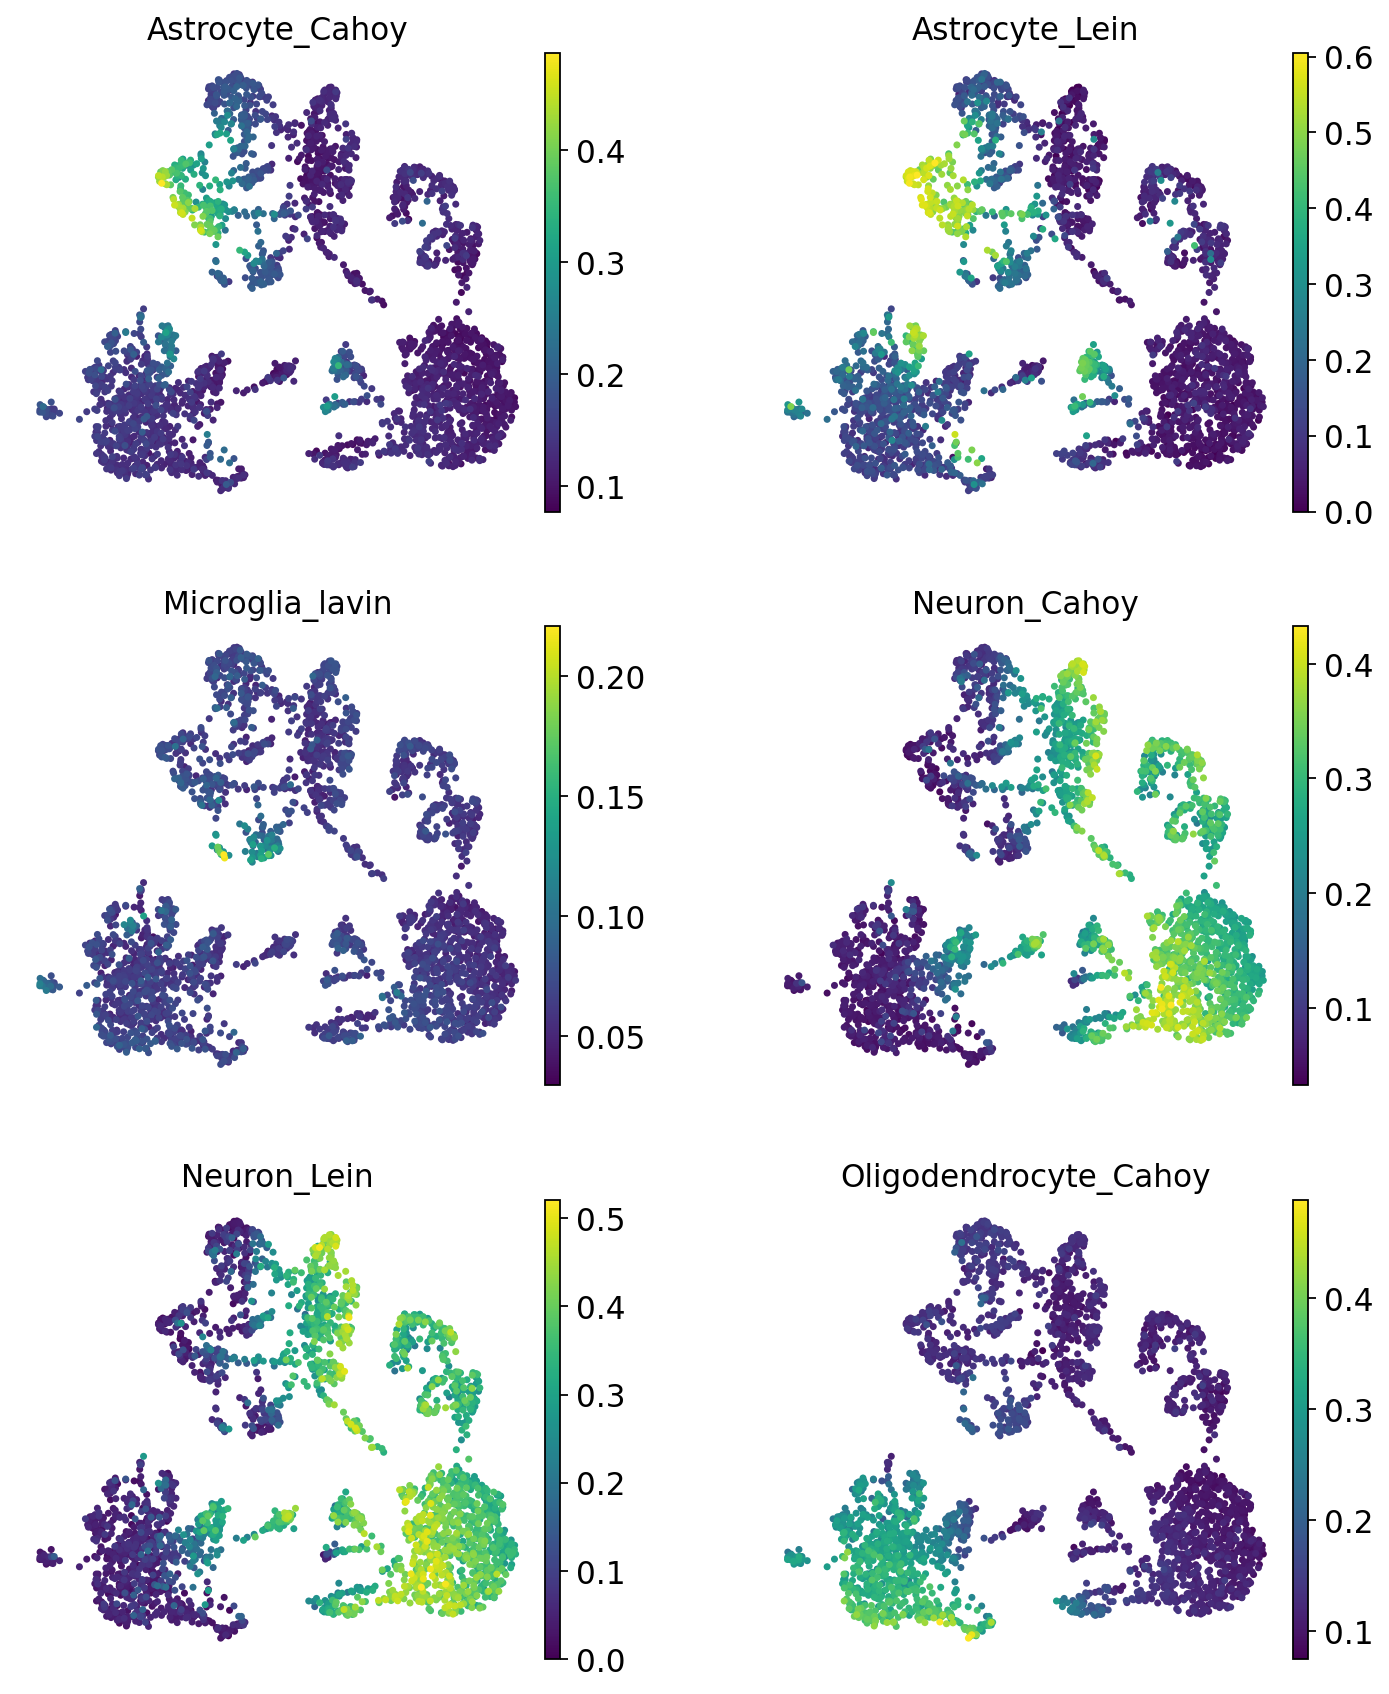

In [34]:
sc.pl.umap(
    adata,
    color=gene_sets_keys,
    frameon=False,
    ncols=2,
    wspace=0.3,
)

## R

In [35]:
gene_set = gene_sets.groupby('geneset').apply(lambda x: x['genesymbol'].tolist()).to_dict()

In [47]:
# adata.X = coo_array(adata.X)
adata.layers['counts'] = adata.X.copy()

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE. 

R[write to console]: 2: useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE. 

R[write to console]: 3: useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE. 



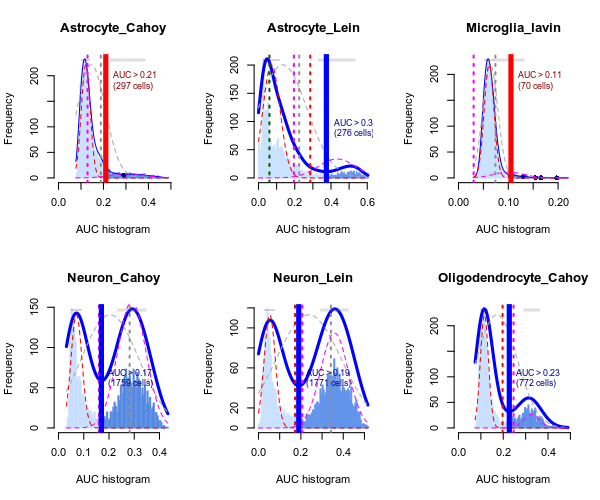

In [48]:
sctk.tools.aucell.AUCell_r(adata, gene_set, n_jobs=5, show=True)

In [50]:
adata.obs[gene_sets_keys] = adata.obsm["AUCell"][gene_sets_keys]

In [51]:
sctk.pp.scanpy_pp(adata)

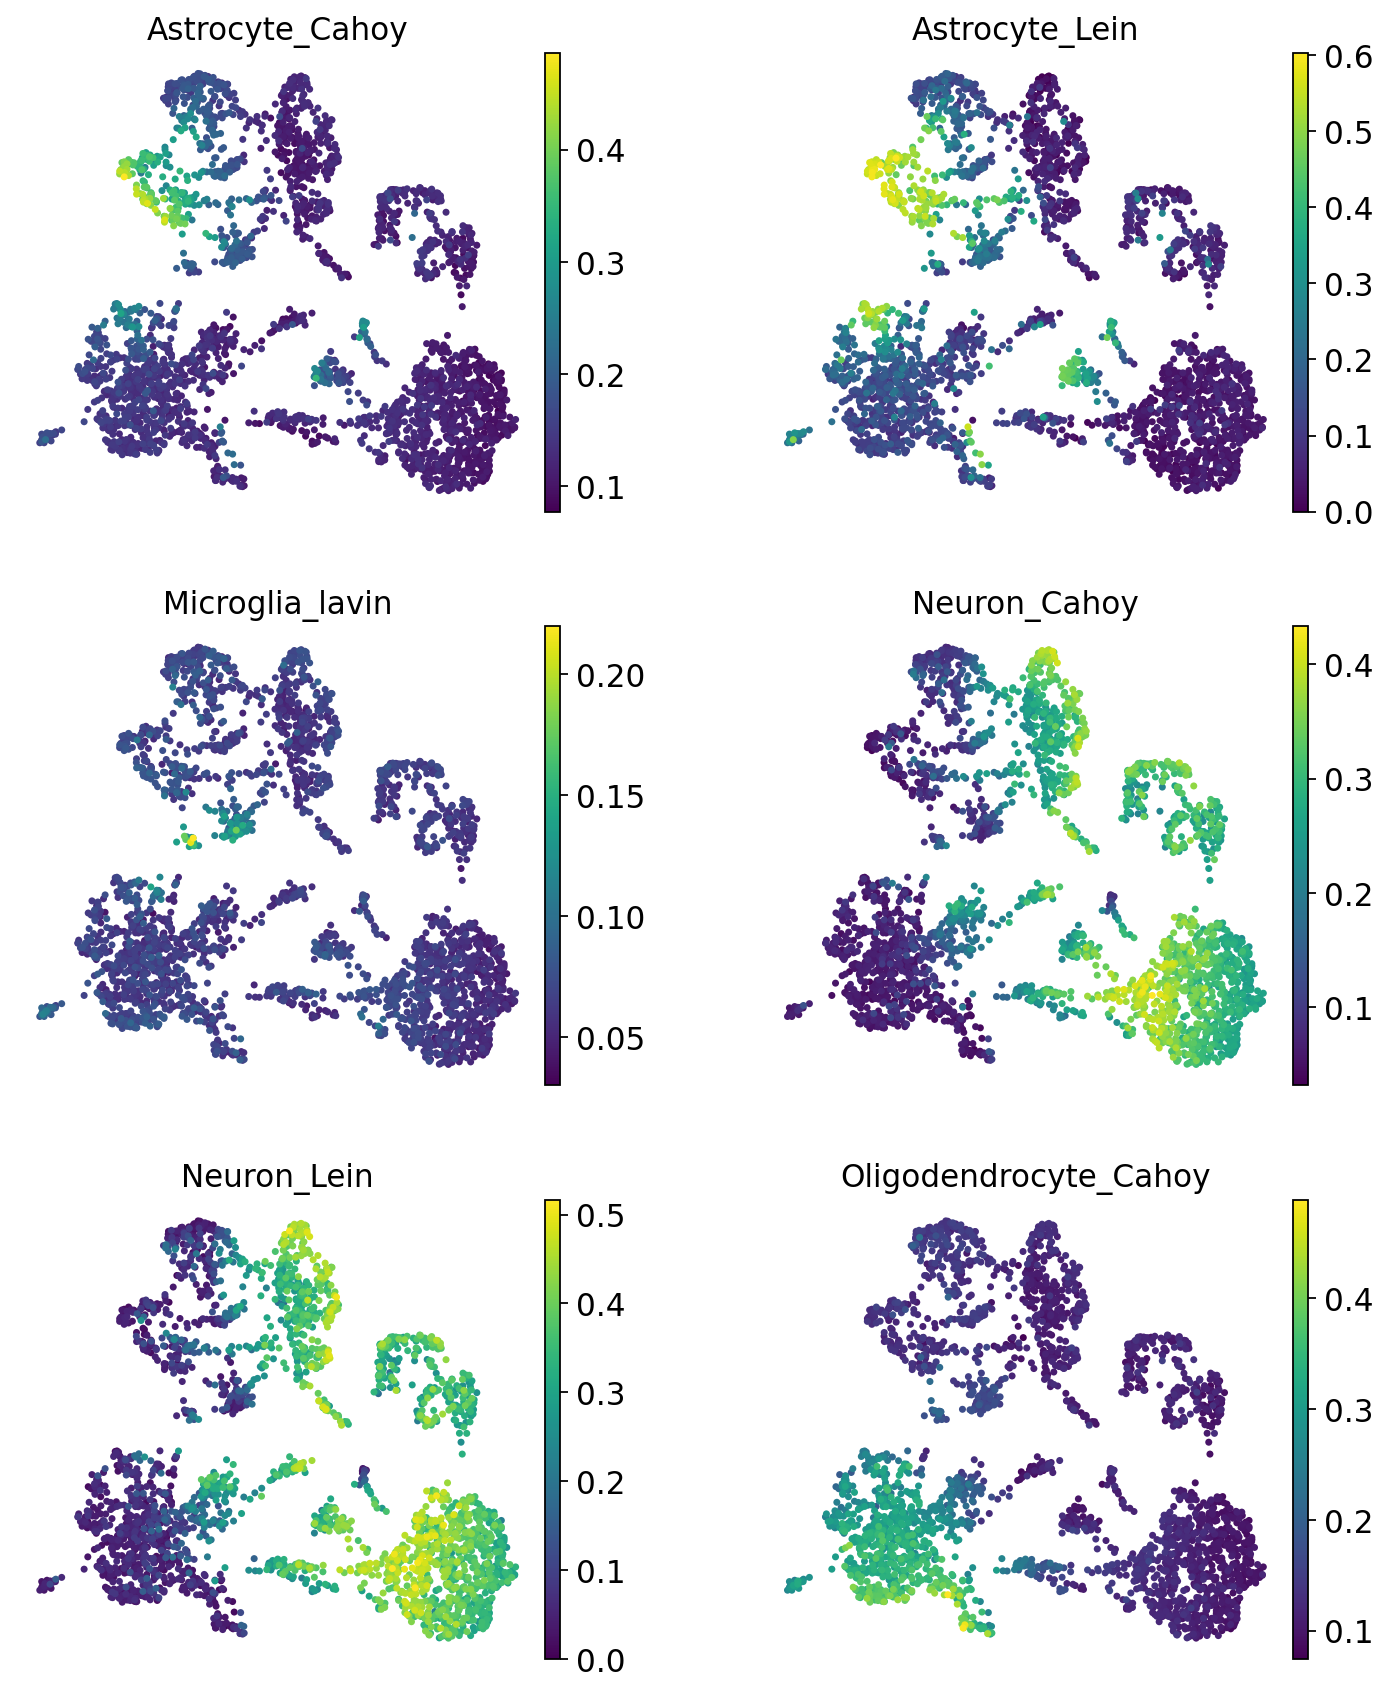

In [52]:
sc.pl.umap(
    adata,
    color=gene_sets_keys,
    frameon=False,
    ncols=2,
    wspace=0.3,
)